https://walkwithfastai.com/Object_Detection

In [1]:
#import numpy as np
#from fastai import *
#from fastai.data.all import *
#from torchvision.models import * 
from fastai.vision.all import *
#from fastai.vision.core import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
path = Path('./data')

In [3]:
imgs, lbl_bbox = get_annotations('./train.json')
img2bbox = dict(zip(imgs, lbl_bbox))
first = {k: img2bbox[k] for k in list(img2bbox)[:1]}; first

{'salmon_20201019_PSCSal_1_Reach1-0_30m_15_T.jpg': ([[48, 926, 63, 1005],
   [124, 664, 143, 727],
   [1026, 505, 1040, 596],
   [1075, 21, 1098, 97],
   [847, 44, 861, 115]],
  ['s', 's', 's', 's', 's'])}

data/train/salmon_20201019_PSCSal_1_Reach1-0_30m_32_T.jpg
([[108, 935, 150, 1011], [209, 828, 243, 935], [-10, 686, 47, 756], [428, 810, 463, 863], [447, 765, 462, 822], [443, 586, 477, 658], [553, 494, 592, 562], [563, 433, 605, 507], [192, 563, 231, 631], [157, 603, 201, 647], [-17, 441, 24, 529], [86, 446, 111, 485], [102, 404, 123, 453], [355, 313, 389, 375], [159, 239, 203, 319], [588, 129, 628, 202], [378, 65, 420, 153], [53, 1, 98, 77]], ['s', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's'])


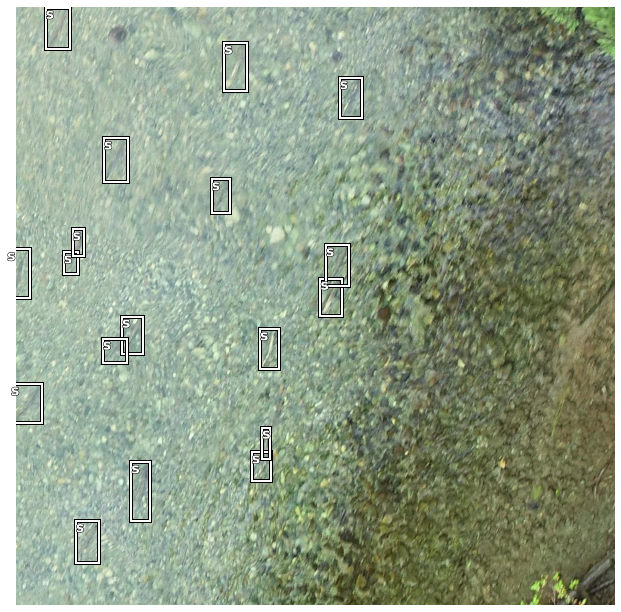

In [4]:
idx=6
fn,bbox = path/'train'/imgs[idx],lbl_bbox[idx]; print(fn); print(bbox)
timg = Transform(PILImage.create)
img = timg(fn)
tbbox = LabeledBBox(TensorBBox(bbox[0]), bbox[1])
ctx = img.show(figsize=(11,11))
tbbox.show(ctx=ctx);

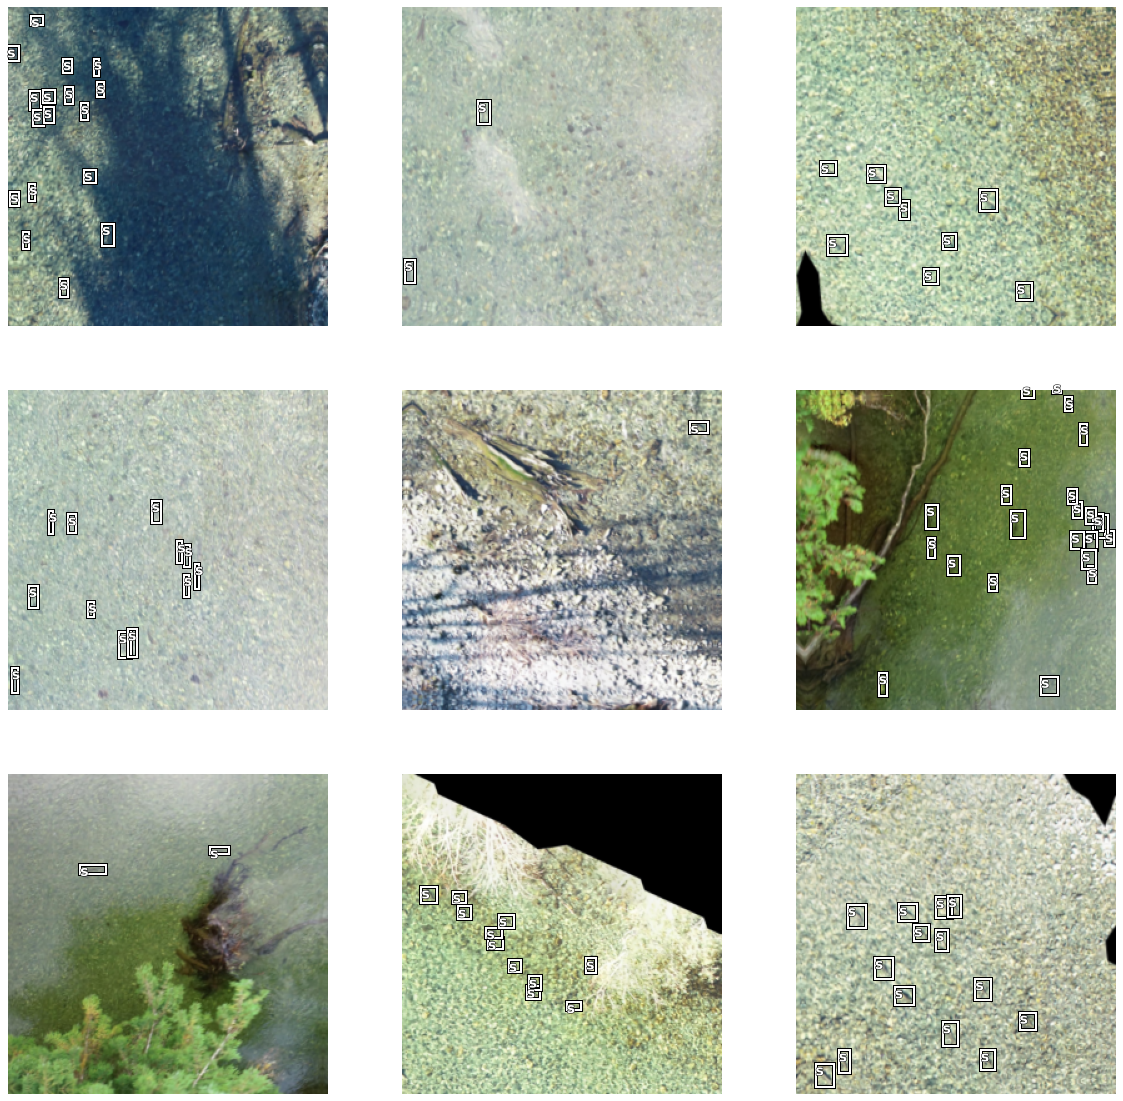

In [11]:
getters = [lambda o: path/'train'/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]


item_tfms = [Resize(256, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(), Normalize.from_stats(*imagenet_stats)]

def get_train_imgs(noop):  return imgs

salmon = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)
                 
dls = salmon.dataloaders(path/'train', bs=9)
dls.c = 20
dls.show_batch(figsize=(20,20))

In [12]:
from wwf.vision.object_detection import *
encoder = create_body(resnet34, pretrained=True)
get_c(dls)

arch = RetinaNet(encoder, get_c(dls), final_bias=-4)
create_head(124, 4)
arch.smoothers
arch.classifier
arch.box_regressor

ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

learn.freeze()

In [13]:
learn.fit_one_cycle(5, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,3.425644,4.522066,00:19
1,7.842219,2.956992,00:11
2,6.235782,3.065954,00:11
3,5.428401,2.959923,00:11
4,4.940048,2.920468,00:11
